In [1]:
import os
import cv2
import json
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm, trange

from lib.utils import isfloat, seed_everything, get_lr
from lib.nerf.model import MyNerfModel
from lib.nerf.utils import get_rays, render_rays, pose_spherical, compute_accumulated_transmittance

seed_everything(seed=42)

In [2]:
folder = "./data/nerf_example_data/nerf_synthetic/lego"
with open(os.path.join(folder, "transforms_train.json"), 'r') as f:
    data_train = json.load(f)
camera_angle_x_train, frames_train = data_train["camera_angle_x"], data_train["frames"]
camera_rotation_train = frames_train[0]["rotation"]
print("camera_angle_x_train", camera_angle_x_train)
print("camera_rotation_train", camera_rotation_train)

camera_angle_x_train 0.6911112070083618
camera_rotation_train 0.012566370614359171


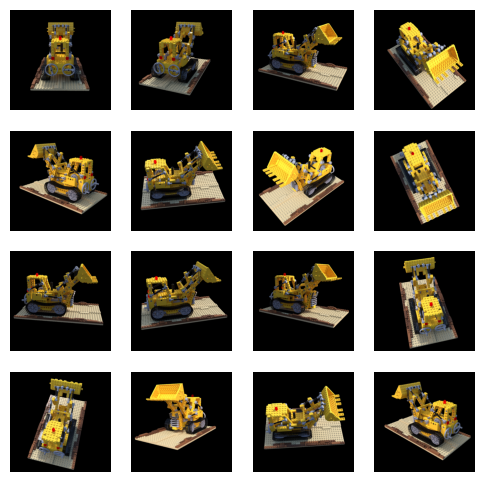

In [3]:
plt.figure(figsize=(6,6))
for i_frame, frame in enumerate(frames_train[:16]):
    f_path = os.path.join(folder, frame["file_path"][2:])+".png"
    t_mat = np.array(frame["transform_matrix"])
    img = cv2.imread(f_path)
    plt.subplot(4,4,i_frame+1)
    plt.axis("off")
    plt.imshow(img[...,::-1])
plt.show()

In [4]:
H, W = 400, 400
training_sets = []
focal = 0.5 *W / np.tan(0.5 * camera_angle_x_train)
for i_frame in trange(len(frames_train)):
    frame = frames_train[i_frame]
    f_path = os.path.join(folder, frame["file_path"][2:])+".png"
    t_mat = np.array(frame["transform_matrix"])
    img = cv2.imread(f_path)
    pixel_colors = cv2.resize(img, (H, W)) / 255.
    rays_o, rays_d = get_rays(H, W, focal, t_mat[:3, :4])
    rays_o, rays_d, pixel_colors = [x.reshape([-1, 3]) for x in [rays_o, rays_d, pixel_colors]]
    training_set = np.concatenate([rays_o, rays_d, pixel_colors], axis = 1)
    training_sets.append(training_set)
training_sets = np.concatenate(training_sets, axis = 0)
training_sets.shape

100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.72it/s]


(16000000, 9)

In [5]:
lr = 5e-4
hn = 2
hf = 6
nb_bins = 192
batch_size = 512
model_path = "./models/my_nerf.pth"
device = torch.device("cpu")

my_model = MyNerfModel(hidden_dim=256).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,8], gamma=0.5)

dataloader = DataLoader(training_sets.astype(np.float32), batch_size=batch_size, shuffle=True)

In [6]:
n_epochs = 1
# n_steps = len(dataloader)
n_steps = 10000 # Due to limited computation power

training_loss = []
start_time = time.time()
for i_epoch in range(n_epochs):
    print("Learning rate =", get_lr(optimizer))
    for i_step, xs in enumerate(dataloader):
        if i_step>=n_steps: break # Due to limited computation power
        
        ray_origins = xs[:,:3].to(device)
        ray_directions = xs[:,3:6].to(device)
        ground_truth_pixels = xs[:,6:].to(device)
        
        regenerated_pixels = render_rays(
            my_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins
        )
        loss = ((ground_truth_pixels - regenerated_pixels) ** 2).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())
        
        if i_step==0 or (i_step+1)%50==0 or i_step+1==len(dataloader):
            # print logs
            time_cost = (time.time() - start_time) / 3600
            print(
                "[Epoch %d/%d][%d/%d]\tLoss: %.4f\tTime: %.4f hrs" % (
                    i_epoch+1, n_epochs, i_step+1, n_steps, loss.item(), time_cost
                )
            )
            torch.save(my_model.state_dict(), model_path)
    
    scheduler.step()
print("Finished")

Learning rate = 0.0005
[Epoch 1/1][1/10000]	Loss: 760.5441	Time: 0.0007 hrs
[Epoch 1/1][50/10000]	Loss: 100.6199	Time: 0.0174 hrs
[Epoch 1/1][100/10000]	Loss: 80.0410	Time: 0.0345 hrs
[Epoch 1/1][150/10000]	Loss: 57.3367	Time: 0.0514 hrs
[Epoch 1/1][200/10000]	Loss: 37.2451	Time: 0.0684 hrs
[Epoch 1/1][250/10000]	Loss: 32.0578	Time: 0.0854 hrs
[Epoch 1/1][300/10000]	Loss: 27.7999	Time: 0.1024 hrs
[Epoch 1/1][350/10000]	Loss: 23.0638	Time: 0.1194 hrs
[Epoch 1/1][400/10000]	Loss: 18.4194	Time: 0.1364 hrs
[Epoch 1/1][450/10000]	Loss: 14.2322	Time: 0.1534 hrs
[Epoch 1/1][500/10000]	Loss: 15.5352	Time: 0.1705 hrs
[Epoch 1/1][550/10000]	Loss: 15.7289	Time: 0.1878 hrs
[Epoch 1/1][600/10000]	Loss: 16.2538	Time: 0.2052 hrs
[Epoch 1/1][650/10000]	Loss: 18.4585	Time: 0.2226 hrs
[Epoch 1/1][700/10000]	Loss: 15.5776	Time: 0.2400 hrs
[Epoch 1/1][750/10000]	Loss: 14.7988	Time: 0.2574 hrs
[Epoch 1/1][800/10000]	Loss: 16.4641	Time: 0.2747 hrs
[Epoch 1/1][850/10000]	Loss: 14.5925	Time: 0.2921 hrs
[Epoch

[Epoch 1/1][7550/10000]	Loss: 5.6039	Time: 2.6203 hrs
[Epoch 1/1][7600/10000]	Loss: 9.5142	Time: 2.6377 hrs
[Epoch 1/1][7650/10000]	Loss: 5.4534	Time: 2.6550 hrs
[Epoch 1/1][7700/10000]	Loss: 4.7357	Time: 2.6725 hrs
[Epoch 1/1][7750/10000]	Loss: 5.9402	Time: 2.6899 hrs
[Epoch 1/1][7800/10000]	Loss: 4.7536	Time: 2.7075 hrs
[Epoch 1/1][7850/10000]	Loss: 5.3348	Time: 2.7256 hrs
[Epoch 1/1][7900/10000]	Loss: 4.2893	Time: 2.7433 hrs
[Epoch 1/1][7950/10000]	Loss: 7.5896	Time: 2.7645 hrs
[Epoch 1/1][8000/10000]	Loss: 6.3515	Time: 2.8007 hrs
[Epoch 1/1][8050/10000]	Loss: 9.2764	Time: 2.8337 hrs
[Epoch 1/1][8100/10000]	Loss: 5.4048	Time: 2.8545 hrs
[Epoch 1/1][8150/10000]	Loss: 4.1266	Time: 2.8778 hrs
[Epoch 1/1][8200/10000]	Loss: 7.5293	Time: 2.9074 hrs
[Epoch 1/1][8250/10000]	Loss: 6.3231	Time: 2.9330 hrs
[Epoch 1/1][8300/10000]	Loss: 4.8047	Time: 2.9567 hrs
[Epoch 1/1][8350/10000]	Loss: 4.0160	Time: 2.9866 hrs
[Epoch 1/1][8400/10000]	Loss: 6.2860	Time: 3.0163 hrs
[Epoch 1/1][8450/10000]	Loss